# Handwritten Digits Classifier

Deep neural networks have been used to reach state-of-the-art performance on image classification tasks in the last decade. For some image classification tasks, deep neural networks actually perform as well as or slightly better than the human benchmark. 

Before the year 2000, institutions like the United States Post Office used handwriting recognition software to read addresses, zip codes, and more. One of their approaches, which consists of pre-processing handwritten images then feeding to a neural network model is detailed in this [paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.852.5499&rep=rep1&type=pdf).

Within the field of machine learning and pattern recognition, image classification (especially for handwritten text) is towards the difficult end of the spectrum. There are a few reasons for this.
- First, each image in a training set is high dimensional. Each pixel in an image is a feature and a separate column. This means that a 128 x 128 image has 16384 features.
- Second, images are often downsampled to lower resolutions and transformed to grayscale (no color). This often results in a loss of detail that's available for training and pattern matching.
- Third, the features in an image don't have an obvious linear or nonlinear relationship that can be learned with a model like linear or logistic regression.

In this notebook, I am going to explore the effectiveness of a deep, feedforward neural network at classifying handwritten digits.

Scikit-learn contains a number of datasets pre-loaded with the library, within the namespace of sklearn.datasets. The load_digits() function returns a copy of the hand-written digits dataset from UCI.

In [1]:
from sklearn.datasets import load_digits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
digits_data = load_digits()
digits_data.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [3]:
labels = pd.Series(digits_data['target'])
data = pd.DataFrame(digits_data['data'])
data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0


Because data frames are a tabular representation of data, each image is represented as a row of pixel values. I am going to load this data, reshape and visualize some of them.

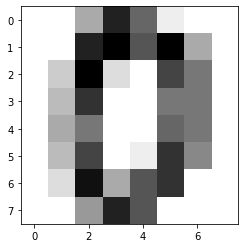

In [4]:
first_image = data.iloc[0]
np_image = first_image.values
np_image = np_image.reshape(8,8)

plt.imshow(np_image, cmap='gray_r')

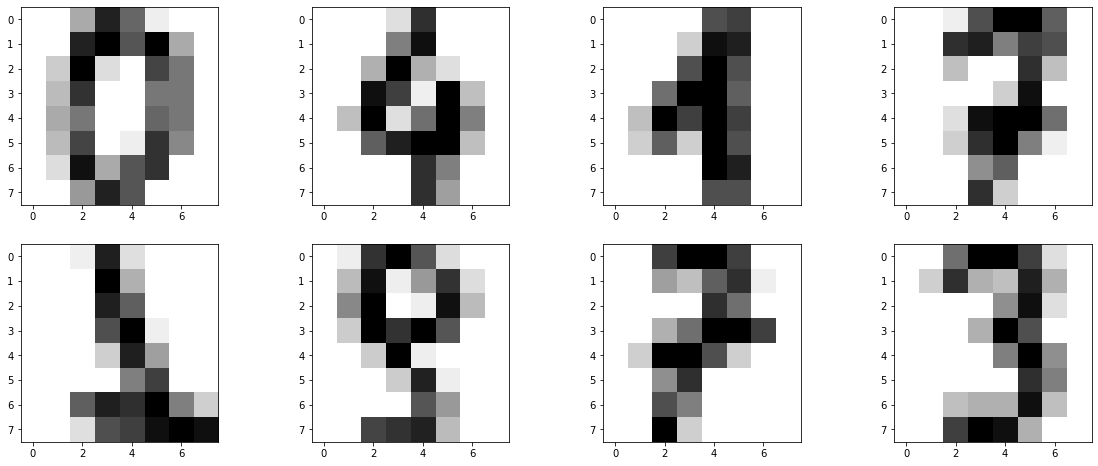

In [5]:
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
rows = [0, 100, 200, 300, 1000, 1100, 1200, 1300]
plt_num = 0
for i in rows:
    image = data.iloc[i] 
    np_image = image.values
    np_image = np_image.reshape(8,8)
    plt_num += 1
    ax = plt.subplot(2,4,plt_num)
    ax.imshow(np_image, cmap='gray_r')

## K-Nearest Neighbors Algorithm

While linear and logistic regression models make assumptions about the linearity between the features and the output labels, the k-nearest neighbors algorithm makes no such assumption. This allows them to capture nonlinearity in the data.

I will setup a pipeline for testing and training k-nn models with 4 fold cross validation

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

def train_knn(nneighbors, train_features, train_labels):
    knn = KNeighborsClassifier(n_neighbors = nneighbors)
    knn.fit(train_features, train_labels)
    return knn

def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df["predicted_label"] == train_test_df["correct_label"])/len(train_test_df)    
    return overall_accuracy

def cross_validate(k):
    fold_accuracies = []
    kf = KFold(n_splits = 4)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        model = train_knn(k, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies
        
knn_one_accuracies = cross_validate(1)
np.mean(knn_one_accuracies)

0.9677233358079684

In [7]:
knn_mean_accuracies = []
for k in range(1, 10):
    accuracies = cross_validate(k)
    knn_mean_accuracies.append(np.mean(accuracies))

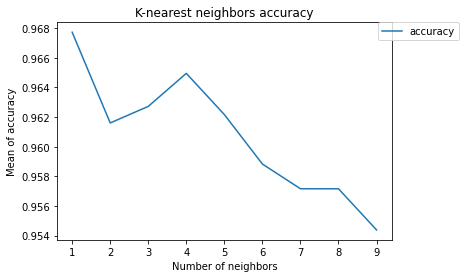

In [8]:
x = range(1, 10)
y = knn_mean_accuracies

plt.plot(x, y, label = 'accuracy')

plt.xlabel('Number of neighbors')
plt.ylabel('Mean of accuracy')
plt.title('K-nearest neighbors accuracy')
plt.legend(bbox_to_anchor=(1.2,1), borderaxespad=0)

In [9]:
knn_mean_accuracies

[0.9677233358079684,
 0.9616010888393962,
 0.9627183865379857,
 0.9649480326651819,
 0.9621665429349171,
 0.9588270230141054,
 0.9571591190299431,
 0.9571578817124474,
 0.9543801039346697]

The highest accuracy is when the number of neighbors is 1. It increased again at k = 4.

## Neural Network With One Hidden Layer

Although I achieved  good results using the KNeighbors model, there are some downsides to this approach. 

1. High memory usage, meaning that for each new unseen observation, there are many comparisons that must be made to seen observations. 
2. No  model representation  to debug and explore.


Now I'll try a neural network with a single hidden layer to see if it outperforms the KNN model. I'll use the MLPClassifier package from scikit-learn. 

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier

# 50% Train / test validation
def train_nn(neuron_arch, train_features, train_labels):
    mlp = MLPClassifier(hidden_layer_sizes=neuron_arch)
    mlp.fit(train_features, train_labels)
    return mlp

def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df["predicted_label"] == train_test_df["correct_label"])/len(train_test_df)    
    return overall_accuracy

def cross_validate(neuron_arch):
    test_accuracies = []
    train_accuracies = []
    kf = KFold(n_splits = 4, random_state=2)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
       
        model = train_nn(neuron_arch, train_features, train_labels)
        test_accuracy = test(model, test_features, test_labels)
        test_accuracies.append(test_accuracy)
        train_accuracy = test(model, train_features, train_labels)
        train_accuracies.append(train_accuracy)
    return test_accuracies, train_accuracies

In [11]:
nn_one_neurons = [
    (8,),
    (16,),
    (32,),
    (64,),
    (128,),
    (256,)
]
nn_one_train_accuracies = []
nn_one_test_accuracies = []

for n in nn_one_neurons:
    train_accuracy, test_accuracy = cross_validate(n)
    train_mean_accuracy = np.mean(train_accuracy)
    nn_one_train_accuracies.append(train_mean_accuracy)
    test_mean_accuracy = np.mean(test_accuracy)
    nn_one_test_accuracies.append(test_mean_accuracy)



/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

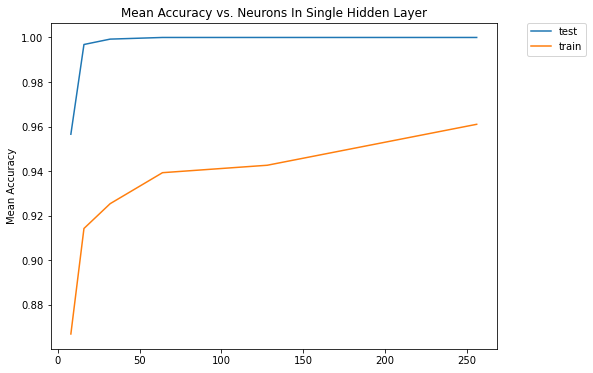

In [12]:
plt.figure(figsize=(8,6))
plt.title("Mean Accuracy vs. Neurons In Single Hidden Layer")

x = [i[0] for i in nn_one_neurons]
plt.plot(x, nn_one_test_accuracies, label='test')
plt.plot(x, nn_one_train_accuracies, label='train')
plt.ylabel('Mean Accuracy')
plt.legend(bbox_to_anchor=(1.2,1), borderaxespad=0)

It looks like adding more neurons to the single hidden layer helped improve simple accuracy from approximately 89% to approximately 95%. The train data gets to 100% very soon, but not with the test data. This could be a sign of over-fitting the data.

Given that k-nearest neighbors achieved approximately 96% accuracy, there doesn't seem to be any advantages to using a single hidden layer neural network for this problem.

## Neural Network 2 Hidden Layers
 
Now I'll try using two hidden layers


In [13]:
nn_two_neurons = [
    (64,64),
    (128, 128),
    (256, 256)
]

nn_two_train_accuracies = []
nn_two_test_accuracies = []

for n in nn_two_neurons:
    train_accuracy, test_accuracy = cross_validate(n)
    train_mean_accuracy = np.mean(train_accuracy)
    nn_two_train_accuracies.append(train_mean_accuracy)
    test_mean_accuracy = np.mean(test_accuracy)
    nn_two_test_accuracies.append(test_mean_accuracy)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


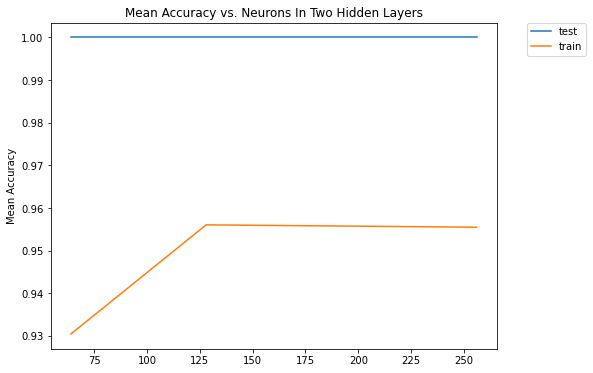

In [14]:
plt.figure(figsize=(8,6))
plt.title("Mean Accuracy vs. Neurons In Two Hidden Layers")

x = [i[0] for i in nn_two_neurons]
plt.plot(x, nn_two_test_accuracies, label='test')
plt.plot(x, nn_two_train_accuracies, label='train')
plt.ylabel('Mean Accuracy')
plt.legend(bbox_to_anchor=(1.2,1), borderaxespad=0)

In [15]:
nn_two_train_accuracies

[0.9304281118535016, 0.9560331601088841, 0.9554776045533284]

Using 2 hidden layers improved our simple accuracy to 95%. Using more hidden layers is known to increase the amount of overfitting that happens. To help prevent overfitting, I'll increase the number of folds  for k-fold cross validation to 6 while testing networks with 3 hidden layers.


## Neural Network 3 Hidden Layers

In [16]:
def cross_validate(neuron_arch):
    test_accuracies = []
    train_accuracies = []
    kf = KFold(n_splits = 6, random_state=2)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
       
        model = train_nn(neuron_arch, train_features, train_labels)
        test_accuracy = test(model, test_features, test_labels)
        test_accuracies.append(test_accuracy)
        train_accuracy = test(model, train_features, train_labels)
        train_accuracies.append(train_accuracy)
    return test_accuracies, train_accuracies

In [17]:
nn_three_neurons = [(10,10,10),
          (64,64,64),
          (128,128,128), 
          (256, 256, 256)]

nn_three_train_accuracies = []
nn_three_test_accuracies = []

for n in nn_three_neurons:
    train_accuracy, test_accuracy = cross_validate(n)
    train_mean_accuracy = np.mean(train_accuracy)
    nn_three_train_accuracies.append(train_mean_accuracy)
    test_mean_accuracy = np.mean(test_accuracy)
    nn_three_test_accuracies.append(test_mean_accuracy)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

In [18]:
nn_three_neurons

[(10, 10, 10), (64, 64, 64), (128, 128, 128), (256, 256, 256)]

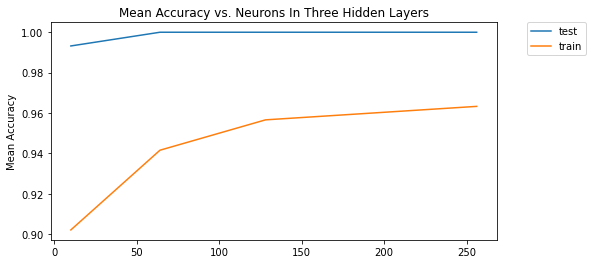

In [19]:
plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons In Three Hidden Layers")

x = [i[0] for i in nn_three_neurons]
plt.plot(x, nn_three_test_accuracies, label='test')
plt.plot(x, nn_three_train_accuracies, label='train')
plt.ylabel('Mean Accuracy')
plt.legend(bbox_to_anchor=(1.2,1), borderaxespad=0)

In [20]:
nn_three_train_accuracies

[0.9020661464139725, 0.941553325901152, 0.956596060943887, 0.9632720178372352]

Using 3 hidden layers improved the simple accuracy to 96%, even with 6-fold cross validation. This seems to be in line with the research literature out there about deep neural networks for computer vision. Having more layers and more neurons tends to improve the network's performance. It still seems overfitted

### Next Steps
- Use the existing pipeline to try other machine learning models:     - Decision Tree Models     - Random Forest Models
- Experiment with different activation functions to see if the accuracies improve.
- Apply some regularization methods to solve overfitting.